This notebook is my recontruction of Andrej Karpathy's MicroGrad libary. It outlines how a topological sort is used to backpropagate an error through a mathematical expression. This is a esentially a heavily simplified version of PyTorch as it only works with scalar values and not vectors which become PyTorch tensors.

GitHub: https://github.com/karpathy/micrograd
Video: https://youtu.be/VMj-3S1tku0

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np 
from graphviz import Digraph
import random

In [7]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # add the edges to the child
                build(child) # recursion. call again to find childs graph
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='TB'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
#     rankdir = 'TB'
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
# wrapper to allow back propagation
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.
        self._backwards = lambda: None # a function to do the back propagation through an operator
        self._prev = set(_children) # keeps track of the pervious Values withut repeats
        self._op = _op # keeps track of the last opertor applied
        self.label = label
        
    def __repr__(self):
        # instead of getting object and pointer you get this print out
        return f"Value(Node: {self.label}|Data: {self.data}|Grad: {self.grad} )"
    
    def __add__(self, other):
        # defines what happend when "+" is called on a Value oject. Called pertor overlaod. 
        # takes in two Value objects and spits out an added Value object
        other = other if isinstance(other, Value) else Value(other) # allows us to add floats/ints to a Value object
        out = Value(self.data+other.data, (self, other), '+')
        
        # define its partial derivative
        def _backwards():
            # out = self.data + other.data 
            # dL/dSelf = dOut/dSelf * dL/dOut
            self.grad += 1.0*out.grad # += needed to accumulate the derivatives ie b=a+a needs gradients from a twice
            other.grad += 1.0*out.grad
        out._backwards = _backwards # assign to the backwasds attriute fucntion 
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self): #(-self) used for a+(-b)
        return -1*self
    
    def __sub__(self, other):
        return self + (-other) # this gets wrapped in __add__
    
    def __rsub__(self, other): # other - self
        return other + (-self)
        
    
    def __mul__(self, other):
        #  self*other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backwards():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backwards = _backwards
        
        return out
    
    def __rmul__(self, other): # python checks this if given 2*a which cant be done with mul as the types arent in the right order
        # # other * self
        return self*other
    
    def __pow__(self, other): # overloads the ** fucntion 
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backwards():
            self.grad += (other*(self.data**(other-1)))*out.grad
        out._backwards = _backwards
    
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backwards():
            self.grad += out.data*out.grad
        out._backwards = _backwards
        
        return out
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backwards():
            self.grad += (1-t**2)*out.grad # derivative of tanh
        out._backwards = _backwards
        
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
        
    def backwards(self):
        # topsort to put nodes in order and backprop the gradient through
        # to be called on the last item in a tree ie loss
        topo = []
        visited = set()
        def build(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build(child)
                topo.append(node)
                
        build(self)
        self.grad=1.0 # sets loss grad to 1 to be propagated backwards
        for node in reversed(topo):
            node._backwards()
        
        
    

In [4]:
# simple example ((a*b)+c)*f
a = Value(2., label='a')
b = Value(3., label='b')
c= Value(7., label='c')
e = a*b; e.label='e'
d= e+c; d.label='d'
f = Value(-2., label='f')
L = d*f; L.label='L'

In [5]:
a-b

Value(Node: |Data: -1.0|Grad: 0.0 )

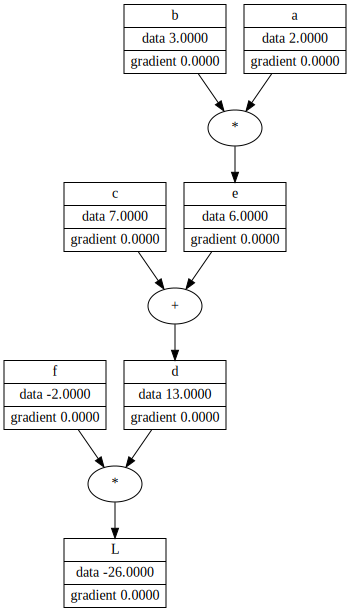

In [8]:
draw_dot(L)

In [17]:
L.backwards()

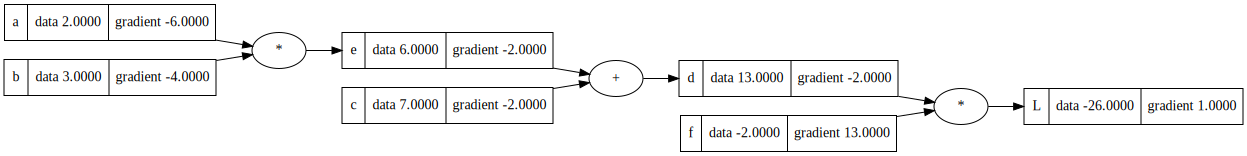

In [18]:
draw_dot(L)

In [111]:
# now make a neuron class

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w.x + b
        # makes an instance act like a function: neuron(x) == neuron.__call__(x)
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)# activation, sum takes bias as the start of the sum 
        out = act.tanh() # non linearity
        return out 
    
    def parameters(self):
        return self.w + [self.b]
    
# and a layer of neurons

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # do the call function on each neuron in the layer 
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
# multi layer perceptron 
class MLP:
    def __init__(self, nin, nouts): # list of nouts
        sz = [nin]+nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # list of layers created by pairing up the right nin nouts
    def __call__(self, x):
        # forward pass
        for layer in self.layers:
            x = layer(x) # sets of the dot procut __call__ chain into the layers and then into each neurons 
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            

In [112]:
x = [2.0, 3.0, -1.0]
n = MLP(4, [4,4,1]) # two layers of 4 and an output of one
n(x) # n.__call__(x) forwards pass

[Value(Node: |Data: 0.3820913243311204|Grad: 0.0 )]